In [11]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import IPython as ip
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [12]:
mpl.style.use('ggplot')
mpl.rc('figure', figsize=(7.2, 5.76))
mpl.rc('font', family='Noto Sans CJK TC')
plt.rc('lines', markeredgecolor='white', markeredgewidth=0.75)
plt.rc('patch', edgecolor='white', force_edgecolor=True, linewidth=1)
ip.display.set_matplotlib_formats('svg')

In [13]:
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn import pipeline
from sklearn import svm
from sklearn import ensemble
from sklearn import metrics

In [14]:
m = sm.datasets.anes96
df = m.load_pandas().data
df_raw = df

In [15]:
df = df_raw
df_X = df[[c for c in df.columns if c != 'vote']]
s_y = df.vote
X_raw = df_X.values
y_raw = s_y.values

In [16]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X_raw, y_raw, test_size=0.4, random_state=20200503
)

In [17]:
pipes = [
    pipeline.make_pipeline(
        preprocessing.StandardScaler(),
        svm.LinearSVC(random_state=20200503),
    ),
    pipeline.make_pipeline(
        preprocessing.MinMaxScaler(),
        svm.LinearSVC(random_state=20200503),
    ),
    pipeline.make_pipeline(
        feature_selection.SelectKBest(feature_selection.f_classif, k=3),
        preprocessing.MinMaxScaler(),
        svm.LinearSVC(random_state=20200503),
    ),
    pipeline.make_pipeline(
        preprocessing.MinMaxScaler(),
        feature_selection.SelectKBest(feature_selection.f_classif, k=3),
        svm.LinearSVC(random_state=20200503),
    ),
    pipeline.make_pipeline(
        ensemble.GradientBoostingClassifier(random_state=20200503),
    ),
    pipeline.make_pipeline(
        preprocessing.StandardScaler(),
        ensemble.GradientBoostingClassifier(random_state=20200503),
    ),
    pipeline.make_pipeline(
        feature_selection.SelectKBest(feature_selection.f_classif, k=3),
        ensemble.GradientBoostingClassifier(random_state=20200503),
    ),
]

cv_list = [
    model_selection.cross_validate(pipe, X_train, y_train)
    for pipe in pipes
]

In [18]:
def get_pipe_name(pipe):
    return '-'.join(s[0] for s in pipe.steps)

,pipe_name,n,fit_time,score_time,test_score
0,standardscaler-linearsvc,0,0.006460,0.000401,0.929825
1,standardscaler-linearsvc,1,0.008838,0.000550,0.876106
2,standardscaler-linearsvc,2,0.007197,0.001054,0.902655
3,standardscaler-linearsvc,3,0.015130,0.001531,0.964602
4,standardscaler-linearsvc,4,0.009219,0.000483,0.876106
5,minmaxscaler-linearsvc,0,0.003632,0.000503,0.929825
6,minmaxscaler-linearsvc,1,0.002579,0.000494,0.876106
7,minmaxscaler-linearsvc,2,0.002446,0.000702,0.911504
8,minmaxscaler-linearsvc,3,0.002522,0.000447,0.964602
9,minmaxscaler-linearsvc,4,0.002619,0.000400,0.884956


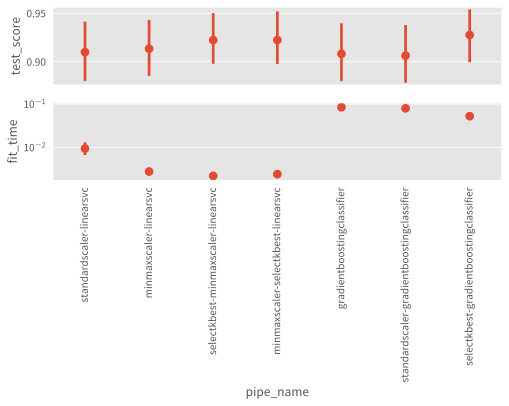

In [19]:
df = pd.concat(map(pd.DataFrame, cv_list),
               keys=map(get_pipe_name, pipes),
               names=['pipe_name', 'n'])
df = df.reset_index()
display(df)
cv_df = df

fig, (ax_u, ax_d) = plt.subplots(2, 1, sharex=True)
sns.pointplot(data=df, x='pipe_name', y='test_score', join=False, ax=ax_u)
ax_u.set_xlabel('')
sns.pointplot(data=df, x='pipe_name', y='fit_time', join=False, ax=ax_d)
plt.xticks(rotation=90)
plt.yscale('log')
fig.tight_layout()

In [20]:
df = cv_df
df = (df
      .groupby('pipe_name')
      [['test_score', 'fit_time']]
      .mean())
df = df.assign(score_per_ftime=df.test_score/df.fit_time)
df = df.sort_values('score_per_ftime')
display(df)

pipe_name_pipe_map = dict(zip(map(get_pipe_name, pipes),
                              pipes))
pipe_name = df.index[-1]
pipe = pipe_name_pipe_map[pipe_name]

pipe.fit(X_train, y_train)
y_test_hat = pipe.predict(X_test)

print(f'The final testing set metrics of {pipe_name}:\n')
print(metrics.classification_report(y_test, y_test_hat))

,test_score,fit_time,score_per_ftime
pipe_name,,,
gradientboostingclassifier,0.908089,0.084434,10.755015
standardscaler-gradientboostingclassifier,0.906319,0.079589,11.387491
selectkbest-gradientboostingclassifier,0.927542,0.052444,17.686183
standardscaler-linearsvc,0.909859,0.009369,97.114822
minmaxscaler-linearsvc,0.913399,0.002760,330.972351
minmaxscaler-selectkbest-linearsvc,0.922264,0.002403,383.732516
selectkbest-minmaxscaler-linearsvc,0.922264,0.002198,419.686884


The final testing set metrics of selectkbest-minmaxscaler-linearsvc:

              precision    recall  f1-score   support

         0.0       0.94      0.89      0.91       226
         1.0       0.85      0.91      0.88       152

    accuracy                           0.90       378
   macro avg       0.89      0.90      0.90       378
weighted avg       0.90      0.90      0.90       378

